# VAE Analysis - Faces dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
W1112 14:01:07.192157 140403513616192 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/hba-gan-gpu-tf14/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1112 14:01:07.194044 140403513616192 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/hba-gan-gpu-tf14/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1112 14:01:07.194939 140403513616192 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/hba-gan-gpu-tf14/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1112 14:01:12.194952 140403513616192 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/hba-gan-gpu-tf14/lib/python3.6/site-packages/kera

['/job:localhost/replica:0/task:0/device:GPU:0']

## imports

In [4]:
import tensorflow as tf
print(tf.__version__)

1.14.0


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
import pandas as pd

from models.VAE import VariationalAutoencoder
from utils.loaders import load_model, ImageLabelLoader

In [18]:
# run params
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])


DATA_FOLDER = './data/celeba/'
IMAGE_FOLDER = './data/celeba/img_align_celeba/'

In [19]:
RUN_FOLDER

'run/vae/0001_faces'

## data

In [59]:
INPUT_DIM = (128,128,3)

# att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.txt'))
att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))

imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])


In [51]:
# att2 = att.rename(columns={'202599': 'image_id'})

In [60]:
att.sample(5)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
89936,089937.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,1,-1,1
147939,147940.jpg,-1,1,1,1,-1,-1,-1,1,1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
96778,096779.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,-1,1
182212,182213.jpg,1,-1,-1,-1,-1,1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
188149,188150.jpg,1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,1,-1,1,-1,-1,-1,-1,-1,1


In [61]:
att.describe()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,...,202599.000000,202599.000000,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000
mean,-0.777728,-0.466039,0.02501,-0.590857,-0.955113,-0.696849,-0.518408,-0.530935,-0.521498,-0.704016,...,-0.886979,-0.035839,-0.583196,-0.360866,-0.62215,-0.903079,-0.055129,-0.754066,-0.854570,0.547234
std,0.628602,0.884766,0.99969,0.806778,0.296241,0.717219,0.855135,0.847414,0.853255,0.710186,...,0.461811,0.999360,0.812333,0.932620,0.78290,0.429475,0.998482,0.656800,0.519338,0.836982
min,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
50%,-1.000000,-1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
75%,-1.000000,1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,1.000000,-1.000000,1.000000,-1.00000,-1.000000,1.000000,-1.000000,-1.000000,1.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


## architecture

In [64]:
vae = load_model(VariationalAutoencoder, RUN_FOLDER)

## reconstructing faces

In [56]:
n_to_show = 10

data_flow_generic = imageLoader.build(att2, n_to_show)


Found 0 images.


Found 202599 images.


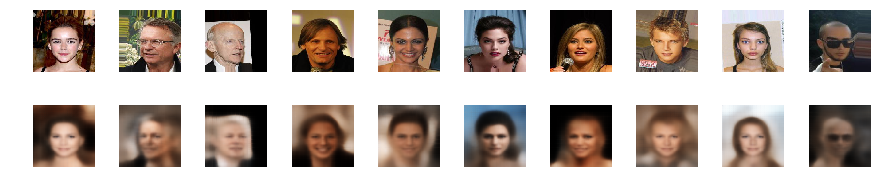

In [65]:
n_to_show = 10

# data_flow_generic = imageLoader.build(att, n_to_show)
data_flow_generic = imageLoader.build(att, n_to_show)

example_batch = next(data_flow_generic)
example_images = example_batch[0]

z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)


## Latent space distribution

20/20 [==============================] - 29s 1s/step


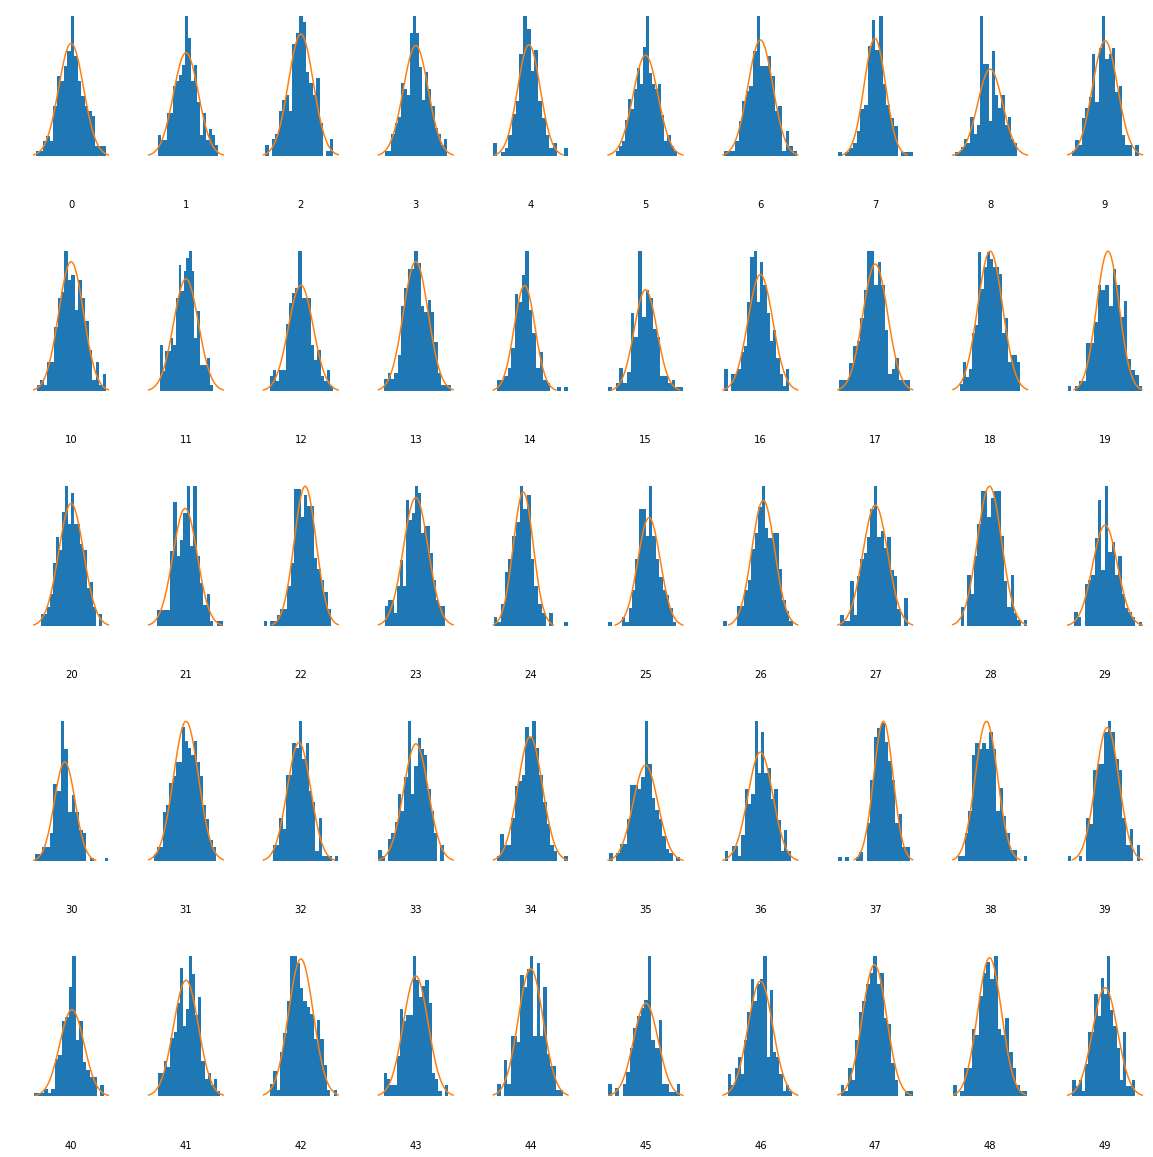

In [66]:
z_test = vae.encoder.predict_generator(data_flow_generic, steps = 20, verbose = 1)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

### Newly generated faces

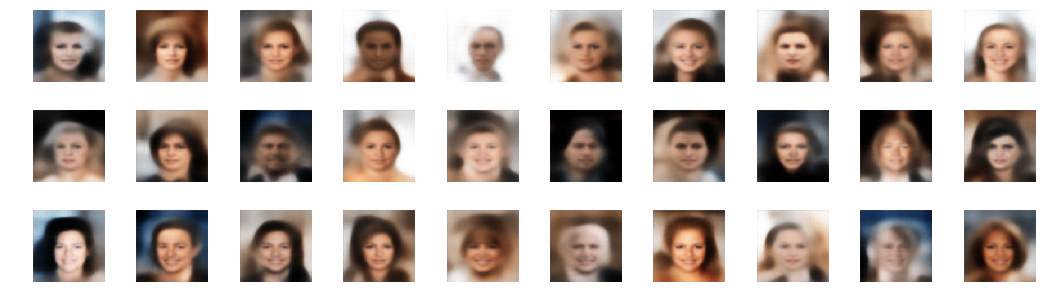

In [67]:
n_to_show = 30

znew = np.random.normal(size = (n_to_show,vae.z_dim))

reconst = vae.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.show()

In [71]:
def get_vector_from_label(label, batch_size):

    data_flow_label = imageLoader.build(att, batch_size, label = label)

    origin = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        z = vae.encoder.predict(np.array(im))

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   


In [72]:
def add_vector_to_images(feature_vec):

    n_to_show = 5
    factors = [-4,-3,-2,-1,0,1,2,3,4]

    example_batch = next(data_flow_generic)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1

    plt.show()


In [73]:
BATCH_SIZE = 500
attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
male_vec = get_vector_from_label('Male', BATCH_SIZE)

Found 202599 images.
label: Attractive
images : POS move : NEG move :distance : 𝛥 distance
277    : 0.927    : 1.067    : 1.583    : 1.583
543    : 0.597    : 0.64    : 1.258    : -0.325
790    : 0.289    : 0.397    : 1.166    : -0.091
1048    : 0.256    : 0.277    : 1.089    : -0.077
1309    : 0.203    : 0.186    : 1.053    : -0.037
1560    : 0.158    : 0.158    : 1.043    : -0.01
1799    : 0.127    : 0.147    : 1.027    : -0.015
2051    : 0.123    : 0.116    : 1.006    : -0.022
2293    : 0.096    : 0.122    : 1.0    : -0.006
2542    : 0.079    : 0.092    : 1.005    : 0.005
2797    : 0.087    : 0.089    : 1.011    : 0.007
3040    : 0.065    : 0.082    : 1.002    : -0.009
3315    : 0.071    : 0.072    : 0.995    : -0.007
3565    : 0.069    : 0.07    : 0.993    : -0.002
3835    : 0.057    : 0.064    : 0.983    : -0.01
4087    : 0.058    : 0.061    : 0.977    : -0.007
4342    : 0.053    : 0.057    : 0.985    : 0.008
4596    : 0.05    : 0.053    : 0.983    : -0.001
4837    : 0.047    : 0.

In [74]:
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)

Found 202599 images.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
38    : 2.857    : 0.671    : 2.926    : 2.926
74    : 1.596    : 0.463    : 2.499    : -0.427
119    : 0.884    : 0.26    : 2.21    : -0.29
149    : 0.597    : 0.177    : 2.15    : -0.06
188    : 0.496    : 0.147    : 2.111    : -0.039
219    : 0.355    : 0.114    : 2.046    : -0.064
261    : 0.351    : 0.103    : 1.941    : -0.105
290    : 0.278    : 0.092    : 1.911    : -0.03
326    : 0.272    : 0.082    : 1.879    : -0.032
358    : 0.227    : 0.069    : 1.831    : -0.048
390    : 0.208    : 0.06    : 1.824    : -0.007
422    : 0.192    : 0.06    : 1.826    : 0.001
452    : 0.175    : 0.051    : 1.79    : -0.036
491    : 0.194    : 0.048    : 1.754    : -0.035
517    : 0.143    : 0.042    : 1.735    : -0.02
545    : 0.144    : 0.039    : 1.715    : -0.02
586    : 0.147    : 0.042    : 1.709    : -0.005
616    : 0.119    : 0.037    : 1.692    : -0.017
661    : 0.166    : 0.036    : 1.679    : 

In [75]:
blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

Found 202599 images.
label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
88    : 1.869    : 0.779    : 2.187    : 2.187
169    : 0.977    : 0.5    : 1.865    : -0.322
242    : 0.558    : 0.281    : 1.743    : -0.121
313    : 0.433    : 0.206    : 1.699    : -0.044
368    : 0.275    : 0.146    : 1.645    : -0.054
444    : 0.293    : 0.116    : 1.648    : 0.003
514    : 0.248    : 0.102    : 1.625    : -0.024
594    : 0.218    : 0.095    : 1.595    : -0.029
659    : 0.162    : 0.09    : 1.555    : -0.04
740    : 0.176    : 0.067    : 1.546    : -0.01
807    : 0.151    : 0.068    : 1.549    : 0.003
878    : 0.136    : 0.062    : 1.539    : -0.01
950    : 0.117    : 0.059    : 1.533    : -0.006
1016    : 0.112    : 0.053    : 1.534    : 0.001
1094    : 0.11    : 0.045    : 1.526    : -0.008
1167    : 0.107    : 0.043    : 1.511    : -0.015
1243    : 0.1    : 0.042    : 1.515    : 0.005
1330    : 0.102    : 0.038    : 1.507    : -0.008
1399    : 0.078    : 0.038    : 1.499

In [76]:
print('F')

F


Eyeglasses Vector


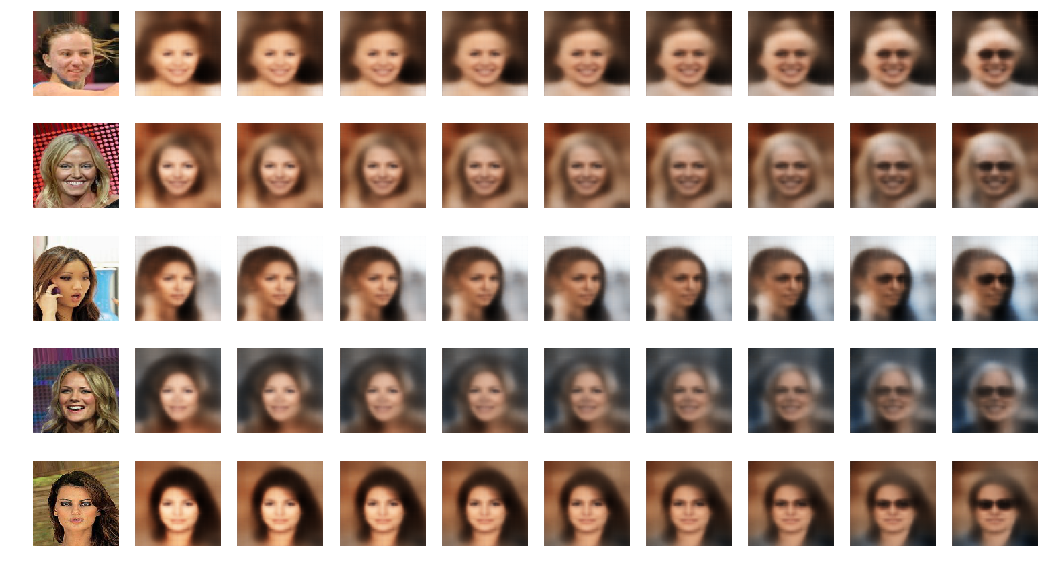

In [77]:
# print('Attractive Vector')
# add_vector_to_images(attractive_vec)

# print('Mouth Open Vector')
# add_vector_to_images(mouth_open_vec)

# print('Smiling Vector')
# add_vector_to_images(smiling_vec)

# print('Lipstick Vector')
# add_vector_to_images(lipstick_vec)

# print('Young Vector')
# add_vector_to_images(young_vec)

# print('Male Vector')
# add_vector_to_images(male_vec)

print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

# print('Blond Vector')
# add_vector_to_images(blonde_vec)

In [88]:

def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.25)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)


    plt.show()

Found 2 images.


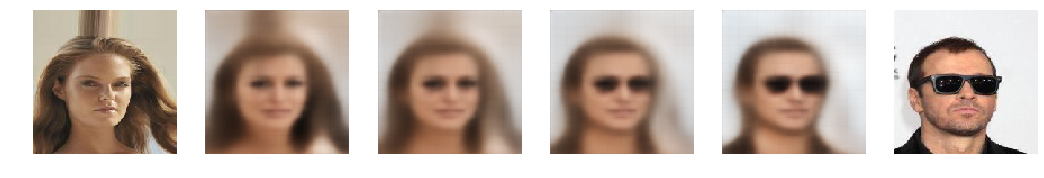

In [89]:
start_image_file = '000238.jpg' 
end_image_file = '000193.jpg' #glasses

morph_faces(start_image_file, end_image_file)

Found 2 images.


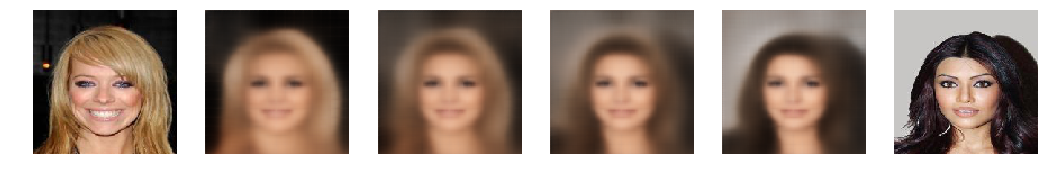

In [90]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 images.


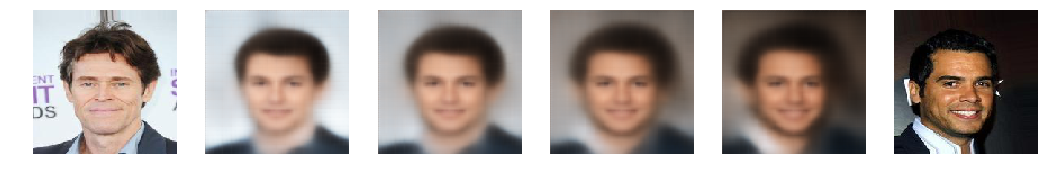

In [91]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)

In [ ]:
start_image_file = 'hba178p.jpg'
end_image_file = '000230.jpg'

morph_faces(start_image_file, end_image_file)

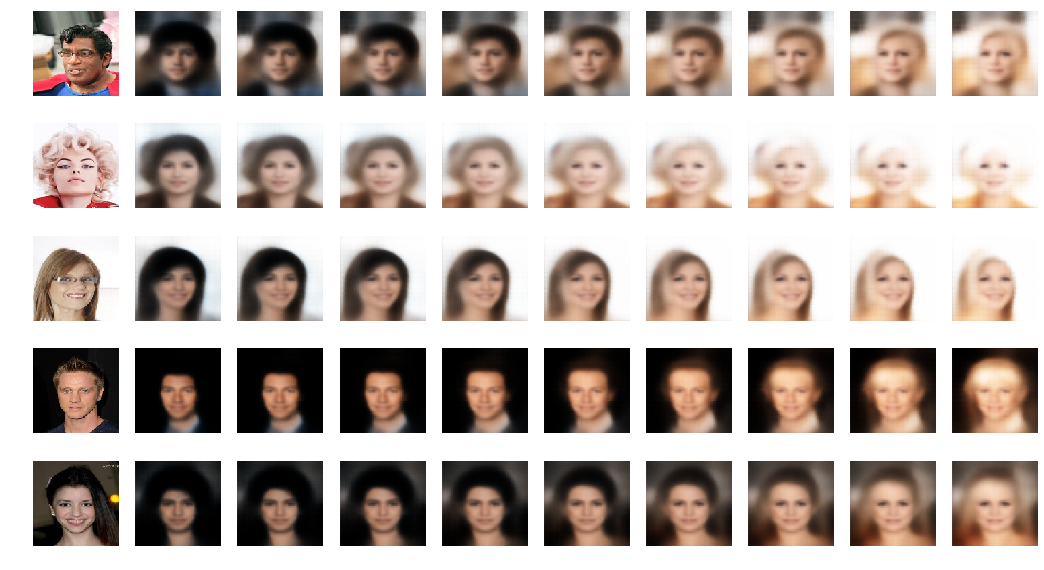

In [94]:
# print('Blond Vector')

add_vector_to_images(blonde_vec)

In [95]:
mustache_vec = get_vector_from_label('Mustache', BATCH_SIZE)

Found 202599 images.
label: Mustache
images : POS move : NEG move :distance : 𝛥 distance
20    : 3.332    : 0.642    : 3.383    : 3.383
34    : 2.031    : 0.437    : 2.853    : -0.53
54    : 1.522    : 0.261    : 2.369    : -0.483
71    : 0.881    : 0.187    : 2.198    : -0.172
95    : 0.872    : 0.154    : 1.978    : -0.219
116    : 0.656    : 0.111    : 1.84    : -0.138
138    : 0.547    : 0.095    : 1.733    : -0.107
166    : 0.427    : 0.091    : 1.655    : -0.078
184    : 0.345    : 0.08    : 1.604    : -0.052
209    : 0.363    : 0.066    : 1.549    : -0.054
229    : 0.291    : 0.061    : 1.508    : -0.041
253    : 0.307    : 0.057    : 1.475    : -0.033
270    : 0.232    : 0.054    : 1.49    : 0.015
283    : 0.197    : 0.046    : 1.485    : -0.005
310    : 0.254    : 0.044    : 1.467    : -0.018
332    : 0.19    : 0.042    : 1.443    : -0.025
355    : 0.21    : 0.04    : 1.432    : -0.011
379    : 0.181    : 0.038    : 1.413    : -0.019
403    : 0.185    : 0.034    : 1.415    : 0

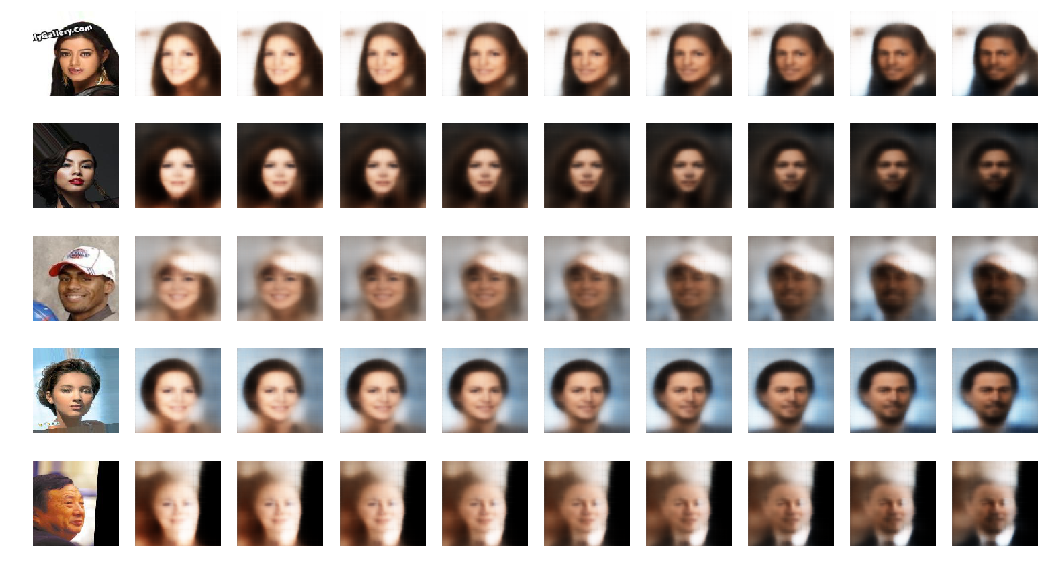

In [96]:
add_vector_to_images(mustache_vec)